# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

## Introduction

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. 

We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000 per year. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. Please refer to the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Let's load necessary Python libraries and load the census data. 

Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [77]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first 10 records
display(data.head(n=10))

age          workclass education_level  education-num  \
0   39          State-gov       Bachelors           13.0   
1   50   Self-emp-not-inc       Bachelors           13.0   
2   38            Private         HS-grad            9.0   
3   53            Private            11th            7.0   
4   28            Private       Bachelors           13.0   
5   37            Private         Masters           14.0   
6   49            Private             9th            5.0   
7   52   Self-emp-not-inc         HS-grad            9.0   
8   31            Private         Masters           14.0   
9   42            Private       Bachelors           13.0   

           marital-status          occupation    relationship    race  \
0           Never-married        Adm-clerical   Not-in-family   White   
1      Married-civ-spouse     Exec-managerial         Husband   White   
2                Divorced   Handlers-cleaners   Not-in-family   White   
3      Married-civ-spouse   Handlers-cleaners         Husband   Black   
4      Married-civ-spouse      Prof-specialty            Wife   Black   
5      Married-civ-spouse     Exec-managerial            Wife   White   
6   Married-spouse-absent       Other-service   Not-in-family   Black   
7      Married-civ-spouse     Exec-managerial         Husband   White   
8           Never-married      Prof-specialty   Not-in-family   White   
9      Married-civ-spouse     Exec-managerial         Husband   White   

       sex  capital-gain  capital-loss  hours-per-week  native-country income  
0     Male        2174.0           0.0            40.0   United-States  <=50K  
1     Male           0.0           0.0            13.0   United-States  <=50K  
2     Male           0.0           0.0            40.0   United-States  <=50K  
3     Male           0.0           0.0            40.0   United-States  <=50K  
4   Female           0.0           0.0            40.0            Cuba  <=50K  
5   Female           0.0           0.0            40.0   United-States  <=50K  
6   Female           0.0           0.0            16.0         Jamaica  <=50K  
7     Male           0.0           0.0            45.0   United-States   >50K  
8   Female       14084.0           0.0            50.0   United-States   >50K  
9     Male        5178.0           0.0            40.0   United-States   >50K

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. The code cell below computes the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [79]:
# Total number of records
n_records = len(data)

#print data['income']
# Number of records where individual's income is more than $50,000
n_greater_50k = sum([(income == '>50K') for income in data['income']])

# Number of records where individual's income is at most $50,000
n_at_most_50k = sum([(income == '<=50K') for income in data['income']])

# Percentage of individuals whose income is more than $50,000
greater_percent = 100 * float(n_greater_50k) / (n_greater_50k + n_at_most_50k)

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Let's plot a histogram of these two features, note the range of values present and how they are distributed.

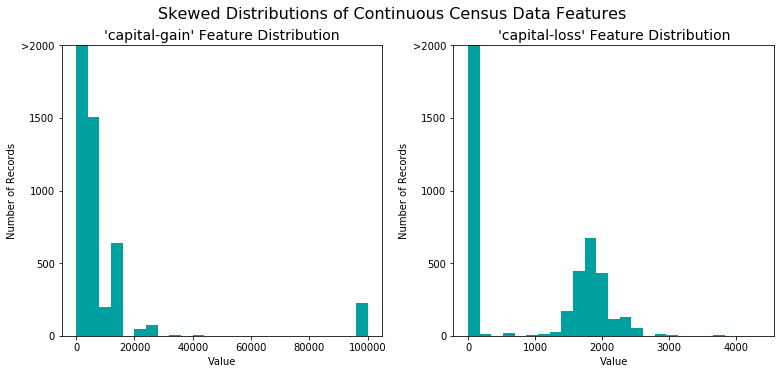

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Let's perform a transformation on the data and visualize results.  

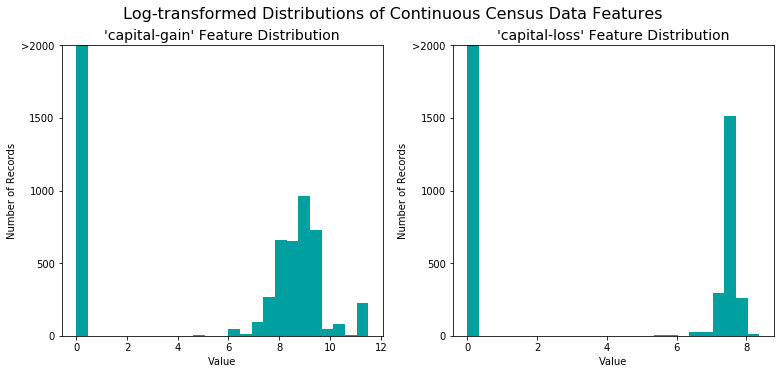

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Let's normalize each numerical feature, using [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [8]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical = ['workclass','education_level','marital-status','occupation', 'relationship', 'race', 'sex', 'native-country']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

age          workclass education_level  education-num  \
0  0.301370          State-gov       Bachelors       0.800000   
1  0.452055   Self-emp-not-inc       Bachelors       0.800000   
2  0.287671            Private         HS-grad       0.533333   
3  0.493151            Private            11th       0.400000   
4  0.150685            Private       Bachelors       0.800000   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0      0.667492           0.0        0.397959   United-States  
1      0.000000           0.0        0.122449   United-States  
2      0.000000           0.0        0.397959   United-States  
3      0.000000           0.0        0.397959   United-States  
4      0.000000           0.0        0.397959            Cuba

### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. 

In code cell below, we will:
 1. Perform one-hot encoding on the `'features_raw'` data with [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies).
 2. Convert the target label `'income_raw'` to numerical entries, setting value for records with "<=50K" to `0` and records with ">50K" to `1`.

In [103]:
import pandas
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pandas.get_dummies(features_log_minmax_transform, columns = categorical)

# Encode the 'income_raw' data to numerical values
#income = (pandas.get_dummies(income_raw))
income = (income_raw[:]=='>50K') * 1


# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded
#print list(income.columns)
print income

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [104]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])
print y_train

Training set has 36177 samples.
Testing set has 9045 samples.
13181    0
10342    0
20881    0
24972    1
43867    0
4124     0
17641    0
17273    0
41191    0
5386     1
28449    0
4955     1
41332    0
33898    1
3413     0
39582    0
33986    0
1797     0
22785    1
36491    0
7267     1
32007    0
41963    1
43769    0
20819    0
28052    0
15274    0
21690    0
7986     0
22296    0
        ..
7599     1
1871     1
18430    1
7877     0
37619    1
5072     1
2163     1
38804    0
6921     1
38984    0
27469    0
16921    0
35665    0
24152    0
43095    1
18983    1
32230    1
17089    0
14650    1
39512    0
15430    1
14935    0
20757    0
41993    1
32103    0
30403    0
21243    1
42613    1
43567    0
2732     0
Name: income, Length: 36177, dtype: int32


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction*, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Reviewing Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset?

In [107]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculate accuracy, precision and recall for naive score always predicts income to be high
TP = np.sum(income)  
TN = 0                  
FP = len(income) - np.sum(income) 
FN = 0

accuracy  = float(TP + TN) / (TP + TN + FP + FN)
recall    = float(TP     ) / (TP + FN)
precision = float(TP     ) / (TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Model Application

This is a classification problem, and I would like to try the following three algorithms:

**Gaussian Naive Bayes classifier:**
* This model can be easily applied in the industry - e.g. for spam detection or pinpointing the author of the E-mail based on words used.
* This model is very fast 
* The main weakness of this model is - it does not take into account dependencies between features
* This is a good initial candidate because it is able to quickly process wide variety of features and establish a benchmark for more sophisticated models

**Decision Tree classifier:**
* This model can be applied to design decision logic for variety of examples that require buy-in from a variety of stakeholders - e.g. deciding on a corporate strategy that needs to be articulated to customers (e.g. customer segmentation for marketing products)
* This model is very easy to articulate and intuitive
* The main weakness/watch-out of this model is - it could easily over-fit the data if allowed to grow in complexity
* This is a good candidate because it can relatively quickly seeth through a lot of data and find relevant patterns based on a large list of attributes

**Gradient Boosting classifier:**
* This model can be be applied in a wide variety of areas where optimal performance is essential, modeling training time and resources are available and the model structure does not need to be articulated, yet results matter. One example that comes to mind is recommendation algorithm for which movie to watch next. 
* This model generalizes well and tends to not over-fit the data as number of iterations grow, provided underlying model being boosted is not too complex.
* The main weakness of this model is - training time/resources needed for optimizing hyper-parameters, which seems to be not an issue
* This is a good candidate because model can be well optimized for accuracy

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model chosen, it's important to create a training and predicting pipeline that allows one to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. 

In the code block below, we will setup a process to:
 1. Fit the learner to the sampled training data 
   - Record the training time.
 2. Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 3. Calculate the accuracy score and F-score for both the training subset and testing set.

In [61]:
# Import two metrics from sklearn
from sklearn.metrics import  fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner.fit(X_train[0:sample_size], y_train[0:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set, and a sample of predictions on the training set
    start = time() # Get start time
    predictions_test  = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] =  fbeta_score(beta=0.5, y_true = y_train[:300], y_pred=predictions_train)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(beta=0.5, y_true = y_test, y_pred=predictions_test)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


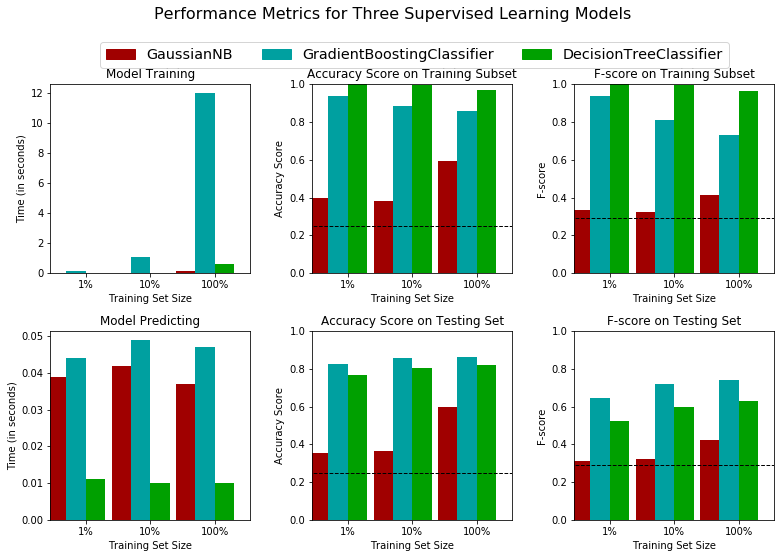

In [109]:
# Import the supervised learning models from sklearn
from sklearn.tree        import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble    import GradientBoostingClassifier

# Initialize the models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state = 17)
clf_C = GradientBoostingClassifier(random_state = 17)
#GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=1.0, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, init=None, random_state=None, max_features=None)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning parameters to improve upon the untuned model's F-score. 

### Choosing the Best Model

Out of the three models tried and with out-of-the-box settings, the gradient boosting algorithm performs better out-of-sample on both accuracy and F-score, and all have acceptable training time.

Decision tree tends to over-fit the data, since both performance metrics on out-of-sample are weaker(less), while naive bayesian tends to under-fit the data, since performance is weaker than other benchmarks.

### Describing the Model in Layman's Terms

The selected model (gradient boosting classifier) - follows 3-step approach to combine many versions of simpler models, leveraging each other's strenghts:

    1) develop a short yes/no questionaire to answer selected question reasonably well

    2) review areas of weakness of selected approach and develop another version of decision process, focusing on the area of weakness; repeat this step many times

    3) combine all the recommendation from the iterations of the decision processes - using a vote system, designed to give some of the versions more say in the matter.

### Implementation: Model Tuning
Fine tune the chosen model using grid search (`GridSearchCV`). 

In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = GradientBoostingClassifier(random_state = 17)
# defaults:
# max_depth=3
# learning_rate=0.1
# n_estimators=100, 
# subsample=1.0, 


# Create the parameters list to be tuned, using a dictionary if needed.
parameters = {
    'learning_rate':           [0.01,  0.1, 0.25], 
    'n_estimators':            [50,    100, 300],
    'min_samples_leaf':        [1,     10,  50],
    'min_samples_split':       [2,     20     ], 
    'min_weight_fraction_leaf':[0.0,   0.05   ],
    'min_impurity_split':      [1e-07, 0.01   ],
    'max_depth':               [3,     6      ]
}

# Make an fbeta_score scoring object using make_scorer()
def performance_metric(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta = 0.5)

scorer = make_scorer(performance_metric, greater_is_better=True)
#y_pred
    
# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf,parameters, scoring = scorer, cv = 5)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

C:\Users\Pasha\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8699
Final F-score on the testing data: 0.7521


### Final Model Evaluation

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |         24.78%      |      86.30%       |      86.99%     |
| F-score        |         29.17%      |      73.95%       |      75.21%     |


The scores are just a little better than unoptimized model, and way better than naive predictor.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Feature Relevance Observation

Based on below chart for one of the version of the models I tried, the key features turn out to be as follows (in descending order of importance):
* capital gain (higher investment income represents people more likely to be making significant income)
* age (higher age represents people more likely to donate)
* number of years of educations (again, higher is better)
* number of hours worked per week (again, higher is better as income increases with number of hours worked)
* marital status 'married' (typically people that marry also work hard to make the income to support this family)

This rank ordering is roughly consistent with intuition

{'presort': 'auto', 'loss': 'deviance', 'verbose': 0, 'subsample': 1.0, 'max_leaf_nodes': None, 'learning_rate': 0.25, 'warm_start': False, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 2, 'init': None, 'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'random_state': 17, 'min_impurity_split': 1e-07, 'max_features': None, 'max_depth': 3}


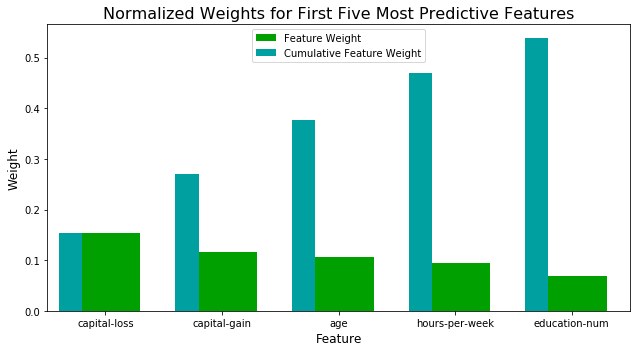

In [113]:
# Import a supervised learning model that has 'feature_importances_'


# Train the supervised model on the training set using .fit(X_train, y_train)
model = None #(already trained best_clf)

# Extract the feature importances using .feature_importances_ 
importances = best_clf.feature_importances_
print best_clf.get_params()
# Plot
vs.feature_plot(importances, X_train, y_train)

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model found earlier, and train it on the same training set *with only the top five important features*. 

In [114]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8699
F-score on testing data: 0.7521

Final Model trained on reduced data
------
Accuracy on testing data: 0.8420
F-score on testing data: 0.6971


### Reviewing Effects of Feature Selection 
* F-score is a bit lower for the model trained on 5 features only; Accuracy is similar thought also a little lower for the simpler model
* The datased with reduced list of features is definitely a good benchmark model, and trade-off between model fit and speed ought to be done based on a) how important is model fit and b) resource availability. In our case, speed is not an issue, hence I would go for more accurate model.